In [ ]:
# TODO: Read: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2309.11798v4
# and https://www.nature.com/articles/s41598-024-58624-4 and https://www.nature.com/articles/s41598-024-58624-4
# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.aimspress.com/aimspress-data/math/2024/2/PDF/math-09-02-178.pdf
# https://ieeexplore.ieee.org/abstract/document/7289461?casa_token=fHhNEidoqJMAAAAA:LM6FsCabVYqQ36U10oWBJSYUmAL4X1_yraUZv51GF3vsfDsp15CrrOFpI-o7PRtfX_JPd9Gog3AGcHQ

In [ ]:
# TODO: Fix the fact that rent is not being added correctly to the edges

In [1]:
import config as cfg
from utils import *
import seaborn as sns
import numpy as np

In [2]:
# Load data
all_viajes = pd.read_csv('/Users/caro/Desktop/thesis_project/mobility_data/VIAJES/all_viajes_month_0322.csv')
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson')
gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson')  # Load your GeoJSON file into a GeoDataFrame
gdf = gdf.to_crs(epsg=4326)

# Filter data
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')]
home_to_work = filtered_df.loc[(filtered_df['actividad_destino'] == 'trabajo_estudio')] # only trips from home to work
short_trips = all_viajes.loc[(all_viajes['distancia']=='0.5-2')]
long_trips = all_viajes.loc[(all_viajes['distancia']=='10-50')]
women = all_viajes.loc[(all_viajes['sexo'] == 'mujer')]
high_income = all_viajes.loc[(all_viajes['renta']=='10-15')]

In [3]:
var_of_interest = 'Median income per consumption unit'

In [4]:
all_viajes['renta'].value_counts()

renta
>15      9975932
10-15    9377769
<10       547254
Name: count, dtype: int64

In [18]:
G, trip_counts = define_graph(filtered_df, remove_weak_edges=True, threshold=0.3)
G = update_node_sizes(G, income, var_of_interest)
positions = get_positions(gdf)
edge_widths = set_art(G, 0.1)
plotly_graph(G, positions, edge_widths, var_of_interest)

In [37]:
adj_matrix = nx.adjacency_matrix(G, weight='weight').toarray()
# np.save('adjacency_matrices/all_trips_adj_matrix.npy', adj_matrix)

In [19]:
adj_matrix = get_adj_matrix(G)

In [20]:
adj_matrix

,2807901.0,2807902.0,2807903.0,2807904.0,2807907.0,2807909.0,2807910.0,2807911.0,2807912.0,2807913.0,...,2807905.0,2807915.0,2807906.0,2807908.0,2807916.0,2807917.0,2807918.0,2807919.0,2807920.0,2807921.0
2807901.0,0.629914,0.548320,0.424445,0.448233,0.680910,0.541820,0.404018,0.366079,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2807902.0,0.695677,0.589145,0.508672,0.000000,0.000000,0.355600,0.352097,0.578946,0.580179,0.322985,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2807903.0,0.530303,0.433103,0.541427,0.570428,0.000000,0.000000,0.000000,0.000000,0.000000,0.562414,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2807904.0,0.395276,0.000000,0.455631,0.561041,0.521729,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.572585,0.573650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2807907.0,0.667517,0.000000,0.000000,0.524307,0.572894,0.543529,0.000000,0.000000,0.000000,0.000000,...,0.473647,0.000000,0.532181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2807909.0,0.605509,0.000000,0.000000,0.000000,0.658214,0.784892,0.573398,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.561069,0.657261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2807910.0,0.651097,0.481241,0.000000,0.342739,0.396425,0.758217,0.844714,0.786909,0.000000,0.000000,...,0.352518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2807911.0,0.507187,0.658298,0.000000,0.000000,0.310124,0.354927,0.747149,0.855278,0.709686,0.000000,...,0.324302,0.000000,0.000000,0.000000,0.000000,0.327300,0.000000,0.000000,0.000000,0.000000
2807912.0,0.367732,0.630614,0.000000,0.000000,0.000000,0.000000,0.000000,0.655692,0.672812,0.451400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.606573,0.000000,0.000000,0.000000,0.000000
2807913.0,0.355151,0.571801,0.727423,0.352125,0.000000,0.000000,0.000000,0.000000,0.563199,0.848973,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.459553,0.756704,0.455490,0.000000,0.000000


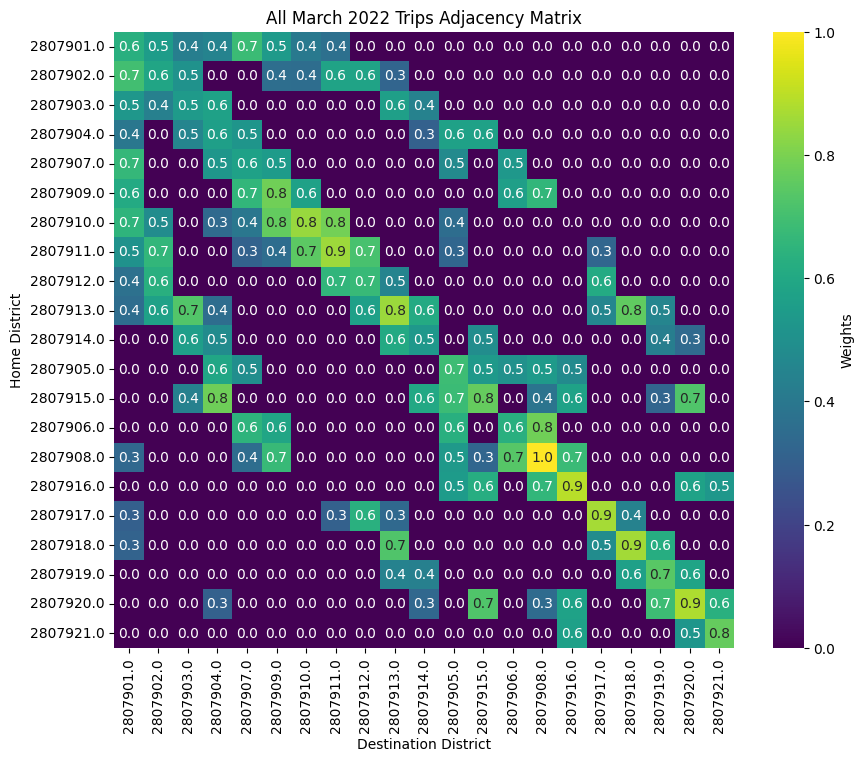

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    adj_matrix, 
    annot=True, 
    cmap='viridis', 
    cbar_kws={'label': 'Weights'}, 
    fmt=".1f"
)
plt.title('All March 2022 Trips Adjacency Matrix')
plt.xlabel('Destination District')
plt.ylabel('Home District');

## General Statistics

In [42]:
G.size(weight="weight")

np.float64(68.37966287609368)

In [45]:
#degree_df = pd.DataFrame(nx.degree(G, weight='weight'),columns=["ID", "degree"])
#degree_df.sort_values("degree", ascending=False)

In [43]:
len(G.edges)

441

In [46]:
#nx.average_clustering(G, weight='weight')

In [47]:
#nx.eigenvector_centrality(G, weight='weight')

In [48]:
#nx.betweenness_centrality(G, weight='weight')

In [49]:
#nx.shortest_path(G, source=2807901, target=2807921, weight='weight')

In [50]:
#print_node_degrees(G)

In [51]:
# Check total in-weights for each node
#in_weights = check_in_weights(G)

In [52]:
# Check total out-weights for each node
#out_weights = check_out_weights(G)

In [35]:
adj_matrix = get_adj_matrix(G)

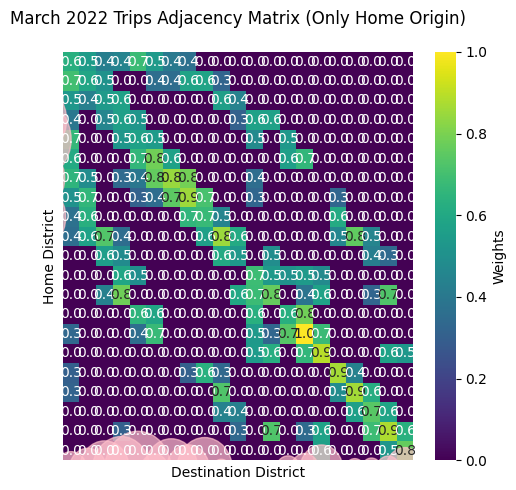

In [24]:
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson')
district_ids = [2807901, 2807902, 2807903, 2807904, 2807905, 2807906, 2807907, 2807908, 2807909, 2807910,
                2807911, 2807912, 2807913, 2807914, 2807915, 2807916, 2807917, 2807918, 2807919, 2807920, 
                2807921]

# Ensure income data is aligned with the district IDs (sorting the income data)
income.set_index('ID', inplace=True)
income_data = income.reindex(district_ids)

# Extract income values and normalize the sizes for better visualization
income_values = income_data['Average income per consumption unit'].values

# Normalize income for scaling the circle size (optional scaling factor to make the circles visible)
min_circle_size = 50  # Minimum size for the circles
max_circle_size = 300  # Maximum size for the circles
income_range = income_values.max() - income_values.min()
circle_sizes = min_circle_size + ((income_values - income_values.min()) / income_range) * (max_circle_size - min_circle_size)

# Plot the adjacency matrix heatmap
plt.figure(figsize=(5, 5))  # Slightly larger figure for readability
ax = sns.heatmap(
    adj_matrix, 
    annot=True,  # Remove the default annotations
    cmap='viridis', 
    cbar_kws={'label': 'Weights'}, 
    fmt=".1f",
    xticklabels=False,  # We'll set custom tick labels below
    yticklabels=False   # We'll set custom tick labels below
)

for i, size in enumerate(circle_sizes):
    # Add circles on x-axis (destination districts)
    circle_x = plt.Circle((i + 0.5, 21.5), radius=size / 150, color='pink', alpha=0.7)
    ax.add_artist(circle_x)
    
    # Add circles on y-axis (home districts)
    circle_y = plt.Circle((-1.5, i + 0.5), radius=size / 150, color='pink', alpha=0.7)
    ax.add_artist(circle_y)

# Add title and labels
plt.title('March 2022 Trips Adjacency Matrix (Only Home Origin)', pad=20)
plt.xlabel('Destination District')
plt.ylabel('Home District')

# Show the plot
plt.tight_layout()
plt.show()

In [43]:
# nx.write_gml(G, "0322_home_origin_graph.gml")

## Trip count analysis

In [45]:
# TODO: stratify trips by renta

In [ ]:
district_mapping = pd.read_csv('/Users/caro/Desktop/thesis_project/data_overview/processed/districts_and_population.csv')

: 

In [ ]:
trip_counts = home_to_work.groupby(['origen', 'destino', 'renta']).size().reset_index(name='trip_count')

: 

In [ ]:
# Step 1: Merge on 'origen' to get the 'name_2' for the 'origen'
trip_counts = trip_counts.merge(district_mapping[['ID', 'name_2']], how='left', left_on='origen', right_on='ID')
trip_counts = trip_counts.rename(columns={'name_2': 'origen_name'})

# Step 2: Merge on 'destino' to get the 'name_2' for the 'destino'
trip_counts = trip_counts.merge(district_mapping[['ID', 'name_2']], how='left', left_on='destino', right_on='ID')
trip_counts = trip_counts.rename(columns={'name_2': 'destino_name'})

# Step 3: Drop the redundant 'ID' columns from the merges
trip_counts = trip_counts.drop(columns=['ID_x', 'ID_y'])

: 

In [35]:
high_rent_df = trip_counts[trip_counts['renta'] == '>15'].sort_values(by='trip_count', ascending=False)
high_rent_top3 = high_rent_df.head(3)
high_rent_bottom3 = high_rent_df.tail(3)

# Filter medium rent (10-15)
medium_rent_df = trip_counts[trip_counts['renta'] == '10-15'].sort_values(by='trip_count', ascending=False)
medium_rent_top3 = medium_rent_df.head(3)
medium_rent_bottom3 = medium_rent_df.tail(3)

# Filter low rent (<10)
low_rent_df = trip_counts[trip_counts['renta'] == '<10'].sort_values(by='trip_count', ascending=False)
low_rent_top3 = low_rent_df.head(3)
low_rent_bottom3 = low_rent_df.tail(3)

# Combine the results into one DataFrame for easy viewing
top3_bottom3_combined = pd.concat([
    high_rent_top3, high_rent_bottom3,
    medium_rent_top3, medium_rent_bottom3,
    low_rent_top3, low_rent_bottom3
])

In [39]:
trip_counts.sort_values(by='trip_count', ascending=False)

,origen,destino,renta,trip_count,origen_name,destino_name
433,2807921,2807914,>15,114,Barajas,Moratalaz
431,2807921,2807912,>15,193,Barajas,Usera
139,2807907,2807914,>15,226,Chamberí,Moratalaz
181,2807909,2807914,>15,270,Moncloa-Aravaca,Moratalaz
429,2807921,2807910,>15,273,Barajas,Latina
...,...,...,...,...,...,...
418,2807920,2807920,10-15,9914,San Blas-Canillejas,San Blas-Canillejas
352,2807917,2807917,10-15,10468,Villaverde,Villaverde
374,2807918,2807918,10-15,10549,Villa de Vallecas,Villa de Vallecas
330,2807916,2807916,>15,10727,Hortaleza,Hortaleza


In [36]:
top3_bottom3_combined

,origen,destino,renta,trip_count,origen_name,destino_name
154,2807908,2807908,>15,11871,Fuencarral-El Pardo,Fuencarral-El Pardo
330,2807916,2807916,>15,10727,Hortaleza,Hortaleza
440,2807921,2807921,>15,9095,Barajas,Barajas
139,2807907,2807914,>15,226,Chamberí,Moratalaz
431,2807921,2807912,>15,193,Barajas,Usera
433,2807921,2807914,>15,114,Barajas,Moratalaz
374,2807918,2807918,10-15,10549,Villa de Vallecas,Villa de Vallecas
352,2807917,2807917,10-15,10468,Villaverde,Villaverde
418,2807920,2807920,10-15,9914,San Blas-Canillejas,San Blas-Canillejas
349,2807917,2807914,10-15,569,Villaverde,Moratalaz


In [30]:
fig = plot_communities(G, positions, nx.community.louvain_communities(G, weight='weight', seed=1234), edge_widths, var_of_interest)

In [31]:
fig.show()

In [21]:
# fig.write_html("madrid_districts_mobility.html")

## Testing Infomap

In [23]:
edges_with_weights = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]

df_edges = pd.DataFrame(edges_with_weights, columns=['source', 'target', 'weight'])
df_edges = df_edges[df_edges['weight'] >= 0.3] # NOTE: Infomap only finds 1 community if I leave edges as they are. Hence, I had to cut edges 

df_edges.to_csv('infomap_input.txt', sep=' ', header=False, index=False)

In [52]:
df_edges

,source,target,weight
0,2807901,2807901,0.629914
1,2807901,2807902,0.548320
2,2807901,2807903,0.424445
3,2807901,2807904,0.448233
6,2807901,2807907,0.680910
...,...,...,...
418,2807920,2807920,0.876657
419,2807920,2807921,0.633192
435,2807921,2807916,0.566085
439,2807921,2807920,0.526633


## Community Analysis

In [19]:
communities = nx.community.louvain_communities(G, weight='weight', seed=1234)

In [20]:
len(communities)

4

In [21]:
def average_degree_per_community(G, communities):
    community_avg_in_degrees = []
    community_avg_out_degrees = []
    
    for community in communities:
        in_degrees = [G.in_degree(node,  weight='weight') for node in community]  # Get in-degree for each node
        out_degrees = [G.out_degree(node,  weight='weight') for node in community] 
        avg_in_degree = sum(in_degrees) / len(community)        # Compute average in-degree
        avg_out_degree = sum(out_degrees) / len(community)
        community_avg_in_degrees.append(avg_in_degree)
        community_avg_out_degrees.append(avg_out_degree)
        print(f"Community {community} - Average In-degree: {avg_in_degree} - Average Out-degree: {avg_out_degree}")
    
    return community_avg_in_degrees, community_avg_out_degrees

# Calculate and display average in-degree for each community
average_degree_per_community(G, communities)

Community {np.float64(2807904.0), np.float64(2807905.0), np.float64(2807906.0), np.float64(2807907.0), np.float64(2807908.0), np.float64(2807909.0), np.float64(2807901.0)} - Average In-degree: 4.04637810322813 - Average Out-degree: 4.085801449713595
Community {np.float64(2807910.0), np.float64(2807911.0), np.float64(2807912.0), np.float64(2807917.0), np.float64(2807902.0)} - Average In-degree: 2.8010069155819113 - Average Out-degree: 2.7543263092044943
Community {np.float64(2807913.0), np.float64(2807914.0), np.float64(2807903.0), np.float64(2807918.0), np.float64(2807919.0)} - Average In-degree: 2.6553743583591127 - Average Out-degree: 2.641770286135415
Community {np.float64(2807920.0), np.float64(2807921.0), np.float64(2807915.0), np.float64(2807916.0)} - Average In-degree: 3.1932774459479143 - Average Out-degree: 3.1996424378497426


([np.float64(4.04637810322813),
  np.float64(2.8010069155819113),
  np.float64(2.6553743583591127),
  np.float64(3.1932774459479143)],
 [np.float64(4.085801449713595),
  np.float64(2.7543263092044943),
  np.float64(2.641770286135415),
  np.float64(3.1996424378497426)])